In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np
import gzip
import struct

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load MNIST

In [3]:
def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)


# 60000 images, each 784 elements (28 * 28 pixels)
X_train_raw = load_images("mnist/train-images-idx3-ubyte.gz")

# 10000 images, each 784 elements, with the same structure as X_train
X_test_raw = load_images("mnist/t10k-images-idx3-ubyte.gz")

print(X_train_raw.shape)

# X_train, X_test_all = standardize(X_train_raw, X_test_raw)
# X_validation, X_test = np.split(X_test_all, 2)

X_train = X_train_raw.reshape(-1,1,28,28)
X_test  = X_test_raw.reshape(-1,1,28,28)

X_train = np.divide(X_train, 255)
X_test = np.divide(X_test, 255)

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [4]:
def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


# 60K labels, each a single digit from 0 to 9
Y_train = load_labels("mnist/train-labels-idx1-ubyte.gz")

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("mnist/t10k-labels-idx1-ubyte.gz")

/Users/oumotoutsu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


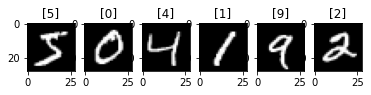

In [5]:
# let's plot few samples
for i in range(0, 6):
    plt.subplot(160 + (i+1))
    plt.imshow(X_train[i,0,:,:], cmap=plt.get_cmap('gray'))
    plt.title(Y_train[i])

## Hyper-parameters 

In [7]:
num_epochs = 50
batch_size = 100
learning_rate = 0.01

## Normalize data and prepare train/val datasets

In [8]:
X_train_tensor = torch.tensor(X_train).to(torch.float32)
# Use torch.squeeze to remove the redundant dim=1 so that size is from [60000, 1] to [60000]
Y_train_tensor = torch.squeeze(torch.tensor(Y_train)).to(torch.int64) 

#Create a train TensorDataset
train_tensor = TensorDataset(X_train_tensor, Y_train_tensor)

#Covert Validation Images from pandas/numpy to tensor and normalize the values
X_test_tensor = torch.tensor(X_test).to(torch.float32)
Y_test_tensor = torch.squeeze(torch.tensor(Y_test)).to(torch.int64)

#Create a Validation TensorDataset
test_tensor = TensorDataset(X_test_tensor, Y_test_tensor)

print(f'Train Labels Shape:,{X_train_tensor.shape}, Y_train.dtype:{X_train_tensor.dtype}')
print(f'Train Labels Shape:,{Y_train_tensor.shape}, Y_train.dtype:{Y_train_tensor.dtype}')

print(f'Train Labels Shape:,{X_test_tensor.shape}, Y_train.dtype:{X_test_tensor.dtype}')
print(f'Train Labels Shape:,{Y_test_tensor.shape}, Y_train.dtype:{Y_test_tensor.dtype}')

#Load Train and Validation TensorDatasets into the data generator for Training 
train_loader = DataLoader(train_tensor, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, num_workers=0, shuffle=True)



Train Labels Shape:,torch.Size([60000, 1, 28, 28]), Y_train.dtype:torch.float32
Train Labels Shape:,torch.Size([60000]), Y_train.dtype:torch.int64
Train Labels Shape:,torch.Size([10000, 1, 28, 28]), Y_train.dtype:torch.float32
Train Labels Shape:,torch.Size([10000]), Y_train.dtype:torch.int64


## Model

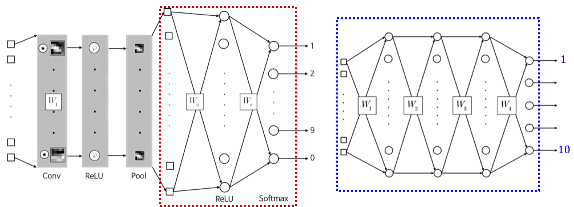

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 9)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(20 * 10 * 10, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = x.view(-1,20 * 10 * 10)    
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = F.relu(self.fc4(x)) 
        x = self.fc5(x)                
        return x

model = ConvNet().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Training

In [11]:
n_total_steps = len(train_loader)
print('n_total_steps =',n_total_steps)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device) 
        labels = labels.to(device) 

        # Forward pass
        outputs = model(images) 
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 300 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

n_total_steps = 600
Epoch [1/50], Step [300/600], Loss: 2.2988
Epoch [1/50], Step [600/600], Loss: 2.3002
Epoch [2/50], Step [300/600], Loss: 2.2770
Epoch [2/50], Step [600/600], Loss: 2.2100
Epoch [3/50], Step [300/600], Loss: 1.2981
Epoch [3/50], Step [600/600], Loss: 0.6644
Epoch [4/50], Step [300/600], Loss: 0.4492
Epoch [4/50], Step [600/600], Loss: 0.3583
Epoch [5/50], Step [300/600], Loss: 0.3450
Epoch [5/50], Step [600/600], Loss: 0.2093
Epoch [6/50], Step [300/600], Loss: 0.2072
Epoch [6/50], Step [600/600], Loss: 0.3464
Epoch [7/50], Step [300/600], Loss: 0.1265
Epoch [7/50], Step [600/600], Loss: 0.2101
Epoch [8/50], Step [300/600], Loss: 0.1405
Epoch [8/50], Step [600/600], Loss: 0.0764
Epoch [9/50], Step [300/600], Loss: 0.0708
Epoch [9/50], Step [600/600], Loss: 0.1285
Epoch [10/50], Step [300/600], Loss: 0.0729
Epoch [10/50], Step [600/600], Loss: 0.1701
Epoch [11/50], Step [300/600], Loss: 0.1084
Epoch [11/50], Step [600/600], Loss: 0.0871
Epoch [12/50], Step [300/600],

## Testing

In [12]:
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')

with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)] 
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item() 
    
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1 
            n_class_samples[label] += 1     

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

print(f'n_class_correct = {n_class_correct},\nn_class_samples = {n_class_samples}')

Accuracy of the network: 98.82 %
Accuracy of 0: 99.28571428571429 %
Accuracy of 1: 99.55947136563877 %
Accuracy of 2: 98.25581395348837 %
Accuracy of 3: 99.00990099009901 %
Accuracy of 4: 99.18533604887983 %
Accuracy of 5: 98.31838565022422 %
Accuracy of 6: 98.53862212943632 %
Accuracy of 7: 98.44357976653697 %
Accuracy of 8: 98.56262833675565 %
Accuracy of 9: 98.90981169474728 %
n_class_correct = [973, 1130, 1014, 1000, 974, 877, 944, 1012, 960, 998],
n_class_samples = [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]
